## 1. Importing Libraries

In [13]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import yaml
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.ModelPrediction import get_prediction,all_pred
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset, EvalImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
from sklearn.model_selection import train_test_split
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
# 4. Wandb Tracker Experiements
import wandb

In [15]:
DATA_PATH      = '../data/ActiveLearning/'
BASE_IMG_DIR   = '/mnt/subfigure-classification'
SEED           = 42
METRIC_MONITOR = "val_avg_loss"
CRITERIA         = 'lc'     
SAMPLES        = 100
DELTA          = 0.05
DELTA_RATIO    = 0.033
MAXIMUM_INTERATIONS = 10
MAX_EPOCHS     = 100 
OUTPUT_DIR     = '/mnt/artifacts/active_learning/higher_modality'

# Reference Code
+ https://blog.scaleway.com/active-learning-pytorch/
+ https://github.com/dhaalves/CEAL_keras/blob/master/CEAL_keras.py
+ http://www.robertmunro.com/
+ https://github.com/ej0cl6/deep-active-learning
+ Book: https://www.manning.com/books/human-in-the-loop-machine-learning

In [4]:
def initialize_dataset(csv_route,new_col='split_set_al'):
    df           = pd.read_csv(csv_route,sep = '\t')
    df_labeled   = df[df['labeled']=='LABELED'].reset_index(drop = True)
    df_unlabaled = df[df['labeled']=='UNLABELED'].reset_index(drop = True)
    df_test      = df[df['labeled']=='TEST'].reset_index(drop = True)
    df_test[new_col] = df_test['labeled']
    df_train_labeled,df_val_labeled,_,_ = train_test_split(df_labeled.copy(),df_labeled['higher_modality'].copy(),random_state=SEED)
    df_train_labeled[new_col] = 'TRAIN'
    df_val_labeled[new_col]   = 'VAL'
    df_start_labeled   = pd.concat([df_train_labeled,df_val_labeled,df_test]).reset_index(drop = True)
    df_start_unlabaled = df_unlabaled.copy()
    
    
    df_start_labeled.to_csv(os.path.join(DATA_PATH,'Labeled_Pool_0.csv'),index = False,sep = '\t')
    df_start_unlabaled.to_csv(os.path.join(DATA_PATH,'Unlabeled_Pool.csv'),index = False,sep = '\t')

In [5]:
def split_dataset(df_labeled,col= 'split_set_al'):
    df_train_labeled,df_val_labeled,_,_ = train_test_split(df_labeled.copy(),df_labeled['higher_modality'].copy(),random_state=SEED)
    df_train_labeled[col] = 'TRAIN'
    df_val_labeled[col]   = 'VAL'
    return pd.concat([df_train_labeled,df_val_labeled]).reset_index(drop = True)

In [6]:
def get_probs(data_loader, model, device):
    # Put the model in eval mode
    model.eval()
    m = nn.Softmax(dim=1)
    # List for store final predictions
    final_probs = []
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            data  = data.to(device)
            probs = model(data)
            probs = m(probs)
            final_probs.append(probs.cpu())
    return np.vstack(final_probs)

In [7]:
# Random sampling
def random_sampling(y_pred_prob, n_samples):
    return np.random.choice(range(len(y_pred_prob)), n_samples)

# Rank all the unlabeled samples in an ascending order according to the least confidence
def least_confidence(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    max_prob = np.max(y_pred_prob, axis=1)
    pred_label = np.argmax(y_pred_prob, axis=1)

    lci = np.column_stack((origin_index,
                           max_prob,
                           pred_label))
    lci = lci[lci[:, 1].argsort()]
    return lci[:, 0].astype(int)[:n_samples]


# Rank all the unlabeled samples in an ascending order according to the margin sampling
def margin_sampling(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    margim_sampling = np.diff(-np.sort(y_pred_prob)[:, ::-1][:, :2])
    pred_label = np.argmax(y_pred_prob, axis=1)
    msi = np.column_stack((origin_index,
                           margim_sampling,
                           pred_label))
    msi = msi[msi[:, 1].argsort()]
    return msi[:n_samples], msi[:, 0].astype(int)[:n_samples]


# Rank all the unlabeled samples in an descending order according to their entropy
def entropy(y_pred_prob, n_samples):
    # entropy = stats.entropy(y_pred_prob.T)
    # entropy = np.nan_to_num(entropy)
    origin_index = np.arange(0, len(y_pred_prob))
    entropy = -np.nansum(np.multiply(y_pred_prob, np.log(y_pred_prob)), axis=1)
    pred_label = np.argmax(y_pred_prob, axis=1)
    eni = np.column_stack((origin_index,
                           entropy,
                           pred_label))

    eni = eni[(-eni[:, 1]).argsort()]
    return eni[:n_samples], eni[:, 0].astype(int)[:n_samples]


def get_high_confidence_samples(y_pred_prob, delta):
    eni, eni_idx = entropy(y_pred_prob, len(y_pred_prob))
    hcs = eni[eni[:, 1] < delta]
    return hcs[:, 0].astype(int), hcs[:, 2].astype(int)


def get_uncertain_samples(y_pred_prob, n_samples, criteria):
    if criteria == 'lc':
        return least_confidence(y_pred_prob, n_samples)
    elif criteria == 'ms':
        return margin_sampling(y_pred_prob, n_samples)
    elif criteria == 'en':
        return entropy(y_pred_prob, n_samples)
    elif criteria == 'rs':
        return None, random_sampling(y_pred_prob, n_samples)
    else:
        raise ValueError(
            'Unknown criteria value \'%s\', use one of [\'rs\',\'lc\',\'ms\',\'en\']' % criteria)


## Dividing Dataset For Experiments

+ Split fot the test set is almost 30% percent, We can keep this in order to test our models in active learning
+ We start with a 10% of labeled images that would be extracted in a stratified way and then we would keep adding images from the unlabeled batch

In [8]:
df_higher_modality     = pd.read_csv('../data/higher_modality_vol1.csv',sep = '\t').drop(columns = ['caption','split_set'])
df_hm_train,df_hm_test = df_higher_modality[df_higher_modality['set']=='TRAIN'].reset_index(drop = True), df_higher_modality[df_higher_modality['set']=='TEST'].reset_index(drop = True)
df_hm_train['labeled'] = 'UNLABELED'
mskf = MultilabelStratifiedKFold(n_splits = 10, shuffle = False)
for fold,(train_index, test_index) in enumerate(mskf.split(df_hm_train, df_hm_train[['source','higher_modality']])):
    if fold == 0:   
        df_hm_train.loc[test_index,'labeled'] = 'LABELED'

# Dataset for Active Learning
df_al = pd.concat([df_hm_train,df_hm_test],axis = 0)
df_al['labeled'] = df_al['labeled'].fillna('TEST') # For Test Set
df_al.to_csv('../data/higher_modality_al.csv',sep = '\t',index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [9]:
pd.read_csv('../data/higher_modality_al.csv',sep = '\t')['labeled'].value_counts()

UNLABELED    9244
TEST         4097
LABELED      1027
Name: labeled, dtype: int64

In [10]:
os.makedirs(DATA_PATH,exist_ok=True)

## Active Learning

In [163]:
df_higher_modality_al = pd.read_csv('../data/higher_modality_al.csv',sep= '\t')
df = pd.read_csv('../data/higher_modality_al.csv', sep='\t')
le_encoder_higher_modality,dict_label = label_encoder_target(df)
del df
dict_label

{'EXPERIMENTAL': 0,
 'GRAPHICS': 1,
 'MICROSCOPY': 2,
 'MOLECULAR': 3,
 'ORGANISMS': 4,
 'OTHER': 5}

In [44]:
# Transformations for mean_std
transform_mean_std =  transforms.Compose([
                                         transforms.ToPILImage(),
                                         transforms.Resize((224, 224)),
                                         transforms.ToTensor()])



# Transformations for train_val_test
train_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                ])

val_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ])

### 1.First Step is get the mean and standard deviation


In [283]:
count     = 0 # Starting the active learning 

In [297]:
print(f'****** Active learning: {count}***********')
initialize_dataset('../data/higher_modality_al.csv')
train_dataset   = ImageDataset    (os.path.join(DATA_PATH,f'Labeled_Pool_{count}.csv'),
                                  le_encoder_higher_modality,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform_mean_std,
                                  label_name='higher_modality',
                                  target_class_col='split_set_al',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=72)
print(f"Mean:  {mean}")
print(f"Std :  {std}")

****** Active learning: 3***********



Mean:  tensor([0.4847, 0.4597, 0.4630])
Std :  tensor([0.3808, 0.3798, 0.3913])


### 2. Second Step is Modeling

In [298]:
dm = ImageDataModule( batch_size           = 32,
                          label_encoder    = le_encoder_higher_modality,
                          data_path        = os.path.join(DATA_PATH,f'Labeled_Pool_{count}.csv'),
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,val_transform],
                          num_workers      = 72,
                          target_class_col ='split_set_al',
                          modality_col     ='higher_modality',
                          path_col         ='img_path')
dm.prepare_data()
dm.setup()
dm.set_seed()

early_stop_callback = EarlyStopping(
    monitor   = METRIC_MONITOR,
    min_delta = 0.0,
    patience  = 5,
    verbose   = True,
    mode      = 'min'
)
# setup model - note how we refer to sweep parameters with wandb.config
num_classes = 6
model = ResNetClass      (name            = 'resnet50',
                          num_classes     = num_classes,
                          pretrained      = True,
                          fine_tuned_from = 'whole',
                          lr              = 1e-3,
                          metric_monitor  = METRIC_MONITOR,
                          mode_scheduler  = "min",
                          class_weights   = dm.class_weights,
                          mean_dataset    = mean,
                          std_dataset     = std)


# setup Trainer
trainer = Trainer(gpus=1,
              max_epochs=2,                  
              callbacks=[early_stop_callback],
              deterministic= True,
              logger = None,
              num_sanity_val_steps=0)

# train
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


1

### 3. Get Confident and uncertain predictions

In [278]:
df_unlabeled = pd.read_csv(os.path.join(DATA_PATH,f'Unlabeled_Pool.csv'),sep = '\t')
df_unlabeled.head()

,img,modality,set,source,img_path,higher_modality,labeled
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-10.jpg,MICROSCOPY,UNLABELED
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-11.jpg,MICROSCOPY,UNLABELED
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-12.jpg,MICROSCOPY,UNLABELED
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-13.jpg,MICROSCOPY,UNLABELED
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-14.jpg,MICROSCOPY,UNLABELED


In [299]:
## Get the confident samples & uncertain samples
df_unlabeled_pool = df_unlabeled[df_unlabeled['labeled']=='UNLABELED'].reset_index(drop = True)
df_unlabeled_pool['img_path'] = df_unlabeled_pool['img_path'].apply(lambda x: BASE_IMG_DIR +'/'+ x)
unlabeled_dataset= EvalImageDataset (df_unlabeled_copy,
                                  image_transform=val_transform,
                                  path_col='img_path')

unlabeled_dataloader = DataLoader(dataset     = unlabeled_dataset,
                          batch_size  = 32,
                          shuffle     = False,
                          num_workers = 72)
unlabeled_probs = get_probs(unlabeled_dataloader,model.to('cuda'),'cuda')

In [300]:
df_unlabeled.shape

(9024, 7)

In [301]:
# Getting the dataset for training and validation 
un_idx       = get_uncertain_samples(unlabeled_probs, SAMPLES,CRITERIA)
df_uncertain = df_unlabeled.iloc[un_idx,:].reset_index(drop = True)

hc_idx,hc_labels = get_high_confidence_samples(unlabeled_probs,DELTA)
df_confidence    = df_unlabeled.iloc[np.array(list(set(hc_idx)-set(un_idx))),:].copy()
df_unlabeled.drop(df_unlabeled.index[np.array(list(set(hc_idx)|set(un_idx)))],inplace = True)

df_confidence.loc[hc_idx,'higher_modality'] = le_encoder_higher_modality.inverse_transform(hc_labels)
df_confidence = df_confidence.reset_index(drop = True)

df_new_dataset = pd.concat([df_uncertain,df_confidence]).reset_index(drop = True)
df_new_dataset['labeled'] = 'LABELED'
df_new_dataset = split_dataset(df_new_dataset)

In [302]:
df_new_dataset

,img,modality,set,source,img_path,higher_modality,labeled,split_set_al
0,1472-6750-10-32-4-3.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1472-6750-10-32-4-3.jpg,GRAPHICS,LABELED,TRAIN
1,1475-2867-6-22-3-4.jpg,GGEL,TRAIN,clef16,2016/train/GGEL/1475-2867-6-22-3-4.jpg,EXPERIMENTAL,LABELED,TRAIN
2,1465-9921-12-111-2-5.jpg,DMLI,TRAIN,clef16,2016/train/DMLI/1465-9921-12-111-2-5.jpg,MICROSCOPY,LABELED,TRAIN
3,1744-9081-2-18-2-4.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1744-9081-2-18-2-4.jpg,GRAPHICS,LABELED,TRAIN
4,1471-2105-10-157-2-6.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1471-2105-10-157-2-6.jpg,GRAPHICS,LABELED,TRAIN
...,...,...,...,...,...,...,...,...
95,1471-2202-11-97-2-3.jpg,DMTR,TRAIN,clef16,2016/train/DMTR/1471-2202-11-97-2-3.jpg,MICROSCOPY,LABELED,VAL
96,1746-1448-1-10-15-2.jpg,GFIG,TRAIN,clef16,2016/train/GFIG/1746-1448-1-10-15-2.jpg,GRAPHICS,LABELED,VAL
97,1471-2121-9-1-4-1.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/1471-2121-9-1-4-1.jpg,MICROSCOPY,LABELED,VAL
98,PMC5030503_ijcpd-04-147-g016.png,DRXR,TRAIN,openi,OPENI_XRAY/PMC5030503_ijcpd-04-147-g016.png,ORGANISMS,LABELED,VAL


In [303]:
df_actual_labeled = pd.read_csv(os.path.join(DATA_PATH,f'Labeled_Pool_{count}.csv'),sep = '\t')
count = count + 1
pd.concat([df_actual_labeled,df_new_dataset]).reset_index(drop = True).to_csv(os.path.join(DATA_PATH,f'Labeled_Pool_{count}.csv'),sep ='\t',index = False)

## Putting all in the loop

In [11]:
df_higher_modality_al = pd.read_csv('../data/higher_modality_al.csv',sep= '\t')
df = pd.read_csv('../data/higher_modality_al.csv', sep='\t')
le_encoder_higher_modality,dict_label = label_encoder_target(df)
del df
dict_label


# Transformations for mean_std
transform_mean_std =  transforms.Compose([
                                         transforms.ToPILImage(),
                                         transforms.Resize((224, 224)),
                                         transforms.ToTensor()])

# 1. Generate the pool of labeled Data & Unlabaled data
initialize_dataset('../data/higher_modality_al.csv')
df_unlabeled = pd.read_csv(os.path.join(DATA_PATH,f'Unlabeled_Pool.csv'),sep = '\t').reset_index(drop = True)

Calculate the Mean & Standard Deviation: 
(1027, 8)



Mean of the Dataset: tensor([0.6384, 0.6349, 0.6352]), Std of the Dataset: tensor([0.3725, 0.3706, 0.3733]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Accuracy: 85.86770629882812
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       224
         1.0       0.93      0.95      0.94      2133
         2.0       0.94      0.79      0.85       873
         3.0       0.62      0.51      0.56       260
         4.0       0.78      0.87      0.82       491
         5.0       0.27      0.49      0.35       116

    accuracy                           0.86      4097
   macro avg       0.73      0.74      0.73      4097
weighted avg       0.87      0.86      0.86      4097


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.7379565208068208,
 'Macro F1-Score': 0.7266396692644421,
 'test_acc': tensor(85.8677, device='cuda:0'),
 'test_loss': tensor(0.4398, device='cuda:0')}
--------------------------------------------------------------------------------
(9244, 7)



DELTA: 0.017
(1650, 7)
Calculate the Mean & Standard Deviation: 
(2777, 8)



Mean of the Dataset: tensor([0.6297, 0.6244, 0.6231]), Std of the Dataset: tensor([0.3610, 0.3612, 0.3638]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Accuracy: 88.16207122802734
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       224
         1.0       0.93      0.96      0.94      2133
         2.0       0.89      0.93      0.91       873
         3.0       0.63      0.60      0.62       260
         4.0       0.94      0.79      0.86       491
         5.0       0.33      0.34      0.33       116

    accuracy                           0.88      4097
   macro avg       0.76      0.73      0.74      4097
weighted avg       0.88      0.88      0.88      4097


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.7340669331070884,
 'Macro F1-Score': 0.7445658992524478,
 'test_acc': tensor(88.1621, device='cuda:0'),
 'test_loss': tensor(0.4015, device='cuda:0')}
--------------------------------------------------------------------------------
(7494, 7)



DELTA: -0.016
(0, 7)
Calculate the Mean & Standard Deviation: 
(2877, 8)



Mean of the Dataset: tensor([0.6332, 0.6271, 0.6253]), Std of the Dataset: tensor([0.3605, 0.3610, 0.3639]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Accuracy: 86.03856658935547
              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81       224
         1.0       0.95      0.92      0.94      2133
         2.0       0.91      0.87      0.89       873
         3.0       0.42      0.70      0.53       260
         4.0       0.94      0.81      0.87       491
         5.0       0.28      0.36      0.32       116

    accuracy                           0.86      4097
   macro avg       0.73      0.74      0.73      4097
weighted avg       0.89      0.86      0.87      4097


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.7367097421055419,
 'Macro F1-Score': 0.7261270168027808,
 'test_acc': tensor(86.0386, device='cuda:0'),
 'test_loss': tensor(0.4746, device='cuda:0')}
--------------------------------------------------------------------------------
(7394, 7)



DELTA: -0.082
(0, 7)
Calculate the Mean & Standard Deviation: 
(2977, 8)



Mean of the Dataset: tensor([0.6322, 0.6266, 0.6243]), Std of the Dataset: tensor([0.3614, 0.3616, 0.3645]) 


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Accuracy: 76.22650909423828
              precision    recall  f1-score   support

         0.0       0.76      0.65      0.70       224
         1.0       0.97      0.79      0.87      2133
         2.0       0.95      0.81      0.87       873
         3.0       0.28      0.83      0.42       260
         4.0       0.94      0.65      0.77       491
         5.0       0.14      0.35      0.20       116

    accuracy                           0.76      4097
   macro avg       0.67      0.68      0.64      4097
weighted avg       0.89      0.76      0.80      4097


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.6824467615014301,
 'Macro F1-Score': 0.6390435531136452,
 'test_acc': tensor(76.2265, device='cuda:0'),
 'test_loss': tensor(0.6490, device='cuda:0')}
--------------------------------------------------------------------------------
(7294, 7)


KeyboardInterrupt: 

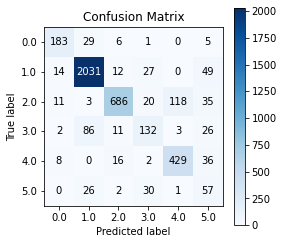

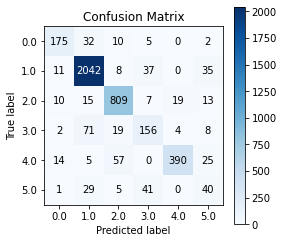

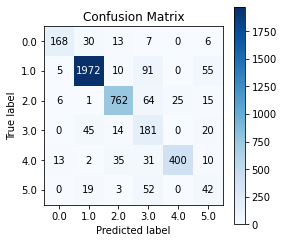

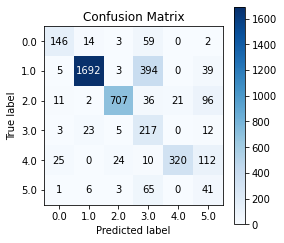

In [64]:
# Iteration Loop

for it in range(MAXIMUM_INTERATIONS):
    # 2. Calculate the Mean and Standard Deviation
    print('Calculate the Mean & Standard Deviation: ')
    train_dataset   = ImageDataset    (os.path.join(DATA_PATH,f'Labeled_Pool_{it}.csv'),
                                      le_encoder_higher_modality,
                                      str(BASE_IMG_DIR),
                                      'TRAIN',
                                      image_transform  = transform_mean_std,
                                      label_name       = 'higher_modality',
                                      target_class_col = 'split_set_al',
                                      path_col         = 'img_path')
    df_ = pd.read_csv(os.path.join(DATA_PATH,f'Labeled_Pool_{it}.csv'),sep = '\t')
    print(df_[df_['labeled']=='LABELED'].shape)


    mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=32)
    print(f"Mean of the Dataset: {mean}, Std of the Dataset: {std} ")

    # 3. Generate the Model
    # 3.1 Setup Data & Data Module
    # Transformations for train_val_test
    train_transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(15),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean,std)
                    ])

    val_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                    ])

    dm = ImageDataModule( batch_size       = 32,
                          label_encoder    = le_encoder_higher_modality,
                          data_path        = os.path.join(DATA_PATH,f'Labeled_Pool_{it}.csv'),
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,val_transform],
                          num_workers      = 32,
                          target_class_col ='split_set_al',
                          modality_col     ='higher_modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()

    
    # 3.2 Setup Modeling
    num_classes = 6
    model = ResNetClass      (name            = 'resnet18',
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = 'whole',
                              lr              = 1e-4,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean,
                              std_dataset     = std)

    # Call backs:
    
    early_stop_callback = EarlyStopping(
        monitor   = METRIC_MONITOR,
        min_delta = 0.0,
        patience  = 5,
        verbose   = True,
        mode      = 'min'
    )

    
    
    checkpoint_callback = ModelCheckpoint(dirpath = os.path.join(OUTPUT_MODEL,f'{}'),
                                      monitor=METRIC_MONITOR,
                                      mode = 'min',
                                      save_top_k = 1)
    
    # 3.3 Setup Trainer
    trainer = Trainer(gpus=1,max_epochs = 5,callbacks=[early_stop_callback],deterministic= True,logger = None,num_sanity_val_steps=0)
    trainer.fit(model, dm)
    
    # 3.4 Save Modeling
    trainer.save_checkpoint(os.path.join(OUTPUT_DIR,f'active_learning_iteration_{it}'))

    # 3.5 Evaluate on the Test Set (Save Metrics):
    trainer.test(model, test_dataloaders=dm.test_dataloader()) # Add Here the precision by class
    del trainer
    # 4. Evaluate on the pool unlabeled data
    df_unlabeled_it = df_unlabeled.copy()
    print(f'{df_unlabeled_it.shape}')
    df_unlabeled_it['img_path'] = df_unlabeled_it['img_path'].apply(lambda x: BASE_IMG_DIR +'/'+ x)
    unlabeled_dataset= EvalImageDataset (df_unlabeled_it,
                                         image_transform=val_transform,
                                         path_col='img_path')

    unlabeled_dataloader = DataLoader(dataset     = unlabeled_dataset,batch_size  = 32,shuffle     = False,num_workers = 32)
    unlabeled_probs = get_probs(unlabeled_dataloader,model.to('cuda'),'cuda')
    del model
    # 4.1 Get the most uncertain examples and the most confident
    # Getting the dataset for training and validation 
    un_idx       = get_uncertain_samples(unlabeled_probs, SAMPLES,CRITERIA)
    df_uncertain = df_unlabeled.iloc[un_idx,:].reset_index(drop = True)

    DELTA = DELTA - (DELTA_RATIO * it)
    print(f'DELTA: {DELTA}')
    hc_idx,hc_labels = get_high_confidence_samples(unlabeled_probs,DELTA)
    df_confidence    = df_unlabeled.iloc[np.array(list(set(hc_idx)-set(un_idx))),:].copy()
    print(df_confidence.shape)
    df_unlabeled.drop(df_unlabeled.index[np.array(list(set(hc_idx)|set(un_idx)))],inplace = True)

    df_confidence.loc[hc_idx,'higher_modality'] = le_encoder_higher_modality.inverse_transform(hc_labels)
    df_confidence = df_confidence.reset_index(drop = True)

    df_new_labeled_pool            = pd.concat([df_uncertain,df_confidence]).reset_index(drop = True)
    df_new_labeled_pool['labeled'] = 'LABELED'
    df_new_labeled_pool            = split_dataset(df_new_labeled_pool)

    df_actual_labeled = pd.read_csv(os.path.join(DATA_PATH,f'Labeled_Pool_{it}.csv'),sep = '\t')
    pd.concat([df_actual_labeled,df_new_labeled_pool]).reset_index(drop = True).to_csv(os.path.join(DATA_PATH,f'Labeled_Pool_{it+1}.csv'),sep ='\t',index = False)